In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate,BatchNormalization,concatenate,LeakyReLU
from keras.applications import vgg16

In [8]:
input_shape = (460, 620, 3)
VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
print('Model loaded.')
output_ = VGG16.output

Model loaded.


In [9]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [10]:
vgg_model = Model(VGG16.input, output_)

In [11]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 460, 620, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 460, 620, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 460, 620, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 230, 310, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 230, 310, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 230, 310, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 115, 155, 128)     0     

In [32]:
input_shape = (256, 512, 3)
base_VGG = vgg16.VGG16(include_top = False, 
                weights = "imagenet", 
                input_shape = input_shape)

# freezing all layers in VGG16 
for layer in base_VGG.layers: 
    layer.trainable = False

# the bridge (exclude the last maxpooling layer in VGG16) 
bridge = base_VGG.get_layer("block5_conv3").output
print(bridge.shape)

# Decoder now
up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
print(up1.shape)
concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
print(up2.shape)
concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
print(up3.shape)
concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
print(up4.shape)
concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
print(conv10.shape)

model = Model(inputs=[base_VGG.input], outputs=[conv10])


(None, 16, 32, 512)
(None, 32, 64, 512)
(None, 64, 128, 256)
(None, 128, 256, 128)
(None, 256, 512, 64)
(None, 256, 512, 3)


In [33]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

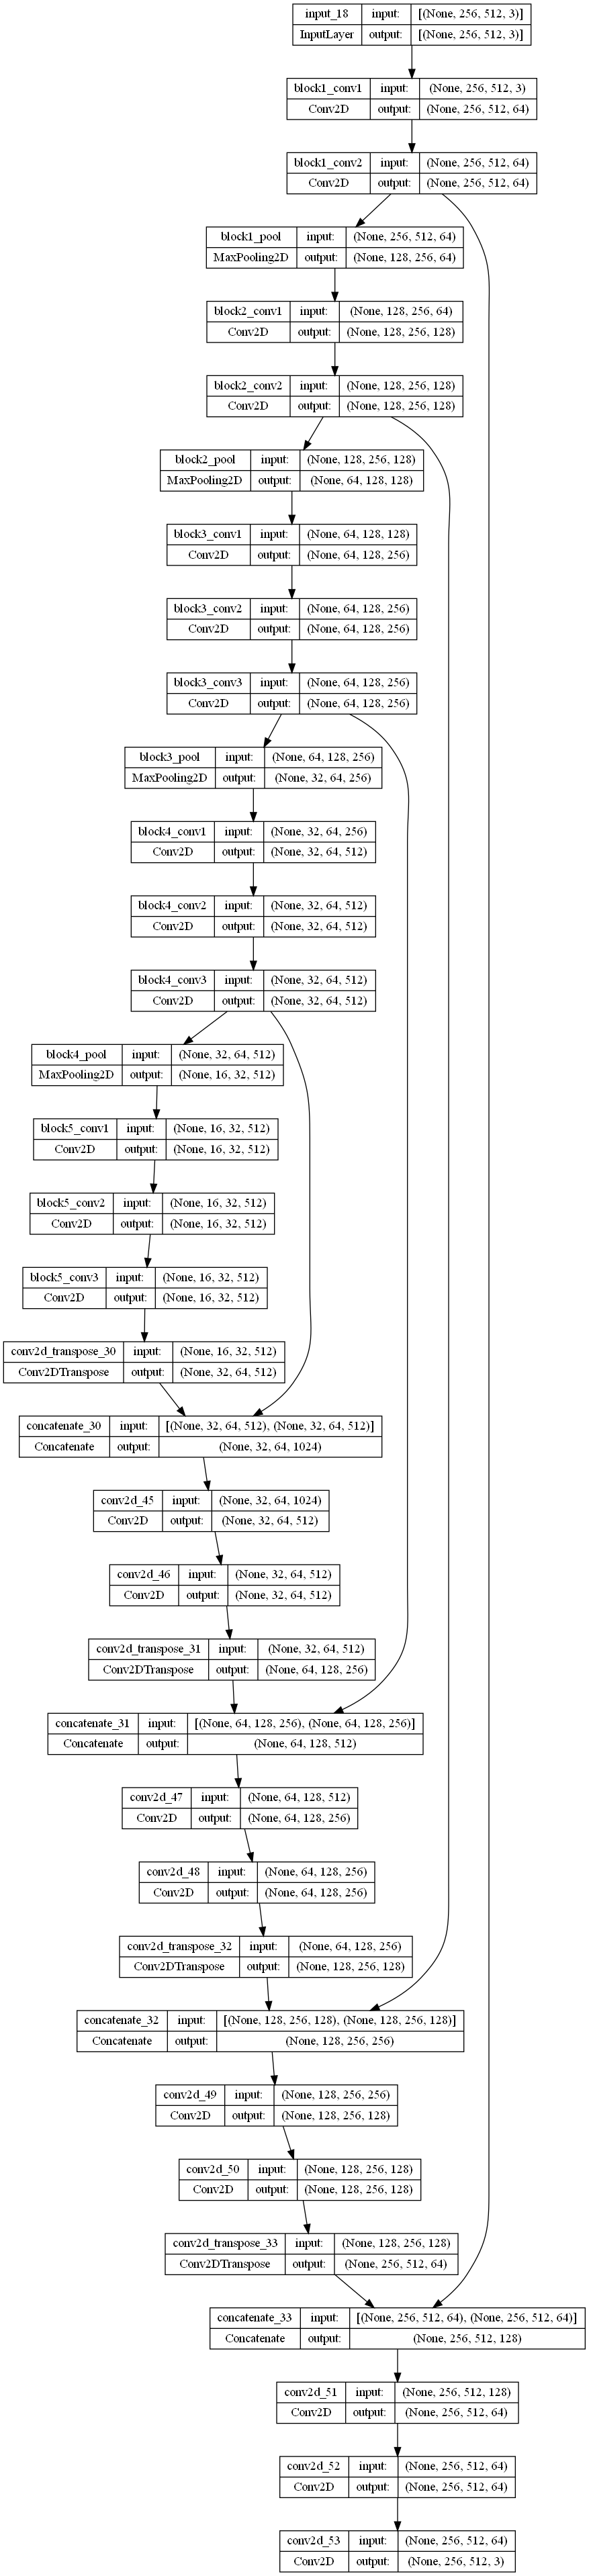

In [34]:
keras.utils.plot_model(model,show_shapes=True)

In [5]:
import keras
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.image import ssim  # Import SSIM

# Define your model and its architecture

# Define loss calculation function
def total_loss(y_true, y_pred):
    lambda_mse = 2.5  # Adjust as needed
    lambda_mae = 2.5
    lambda_ssim = 2  # Adjust as needed
    lambda_color = 20  # Adjust the weight as needed

    # Compute MSE loss
    mse = MeanSquaredError()(y_true, y_pred)

    # Compute MAE loss
    mae = MeanAbsoluteError()(y_true, y_pred)

    # Compute SSIM loss
    ssim_loss = 1 - ssim(y_true, y_pred, max_val=1.0)  # max_val should match your image range (e.g., 0-1)

    # Custom color loss based on color histograms
    def color_loss(y_true, y_pred):
        # Convert the images to grayscale
        y_true_gray = tf.image.rgb_to_grayscale(y_true)
        y_pred_gray = tf.image.rgb_to_grayscale(y_pred)

        # Calculate the MSE between the grayscale images
        color_loss = tf.reduce_mean(tf.square(y_true_gray - y_pred_gray))

        return color_loss
 # Compute color loss
    color = color_loss(y_true, y_pred)

    # Combine losses with weights
    loss = (
        lambda_mse * mse +
        lambda_mae * mae +
        lambda_ssim * ssim_loss +
        lambda_color * color
    )

    return loss

model = tf.keras.models.load_model('model121.h5',custom_objects={'total_loss': total_loss})

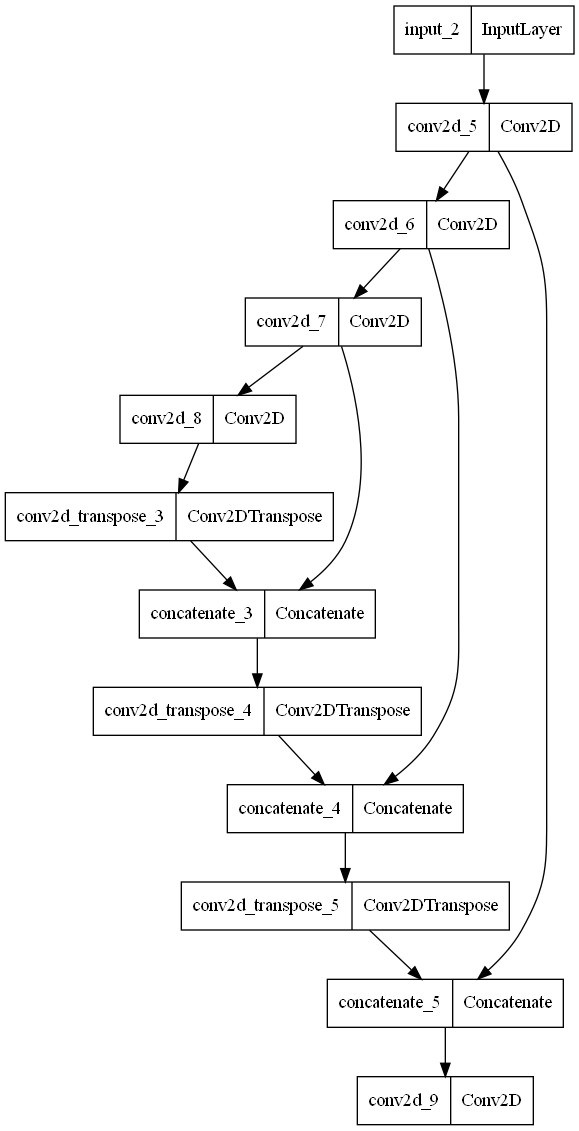

In [6]:
keras.utils.plot_model(model)

In [11]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 12  73856       ['conv2d_5[0][0]']               
                                8)                                                          